<a href="https://colab.research.google.com/github/Akshatpattiwar512/Convolutional-Neural-Network/blob/main/Arabic_Characters_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Exploration

Import libraries necessary for this project.

In [313]:
! pip install pytesseract

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sn
from PIL import Image
from scipy.ndimage import rotate
from IPython.display import display 
from sklearn.metrics import classification_report

import keras
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Load Arabic Letters dataset files into dataframes

In [315]:
# Training letters images and labels files
letters_training_images_file_path = ("csvTrainImages 13440x1024.csv")
letters_training_labels_file_path = ("csvTrainLabel 13440x1.csv")
# Testing letters images and labels files
letters_testing_images_file_path = ("csvTestImages 3360x1024.csv")
letters_testing_labels_file_path = ("csvTestLabel 3360x1.csv")
# Loading dataset into dataframes
training_letters_images = pd.read_csv(letters_training_images_file_path, header=None)
training_letters_labels = pd.read_csv(letters_training_labels_file_path, header=None)
testing_letters_images = pd.read_csv(letters_testing_images_file_path, header=None)
testing_letters_labels = pd.read_csv(letters_testing_labels_file_path, header=None)

# print statistics about the dataset
print("There are %d training arabic letter images of 32x32 pixels." %training_letters_images.shape[0])
print("There are %d testing arabic letter images of 32x32 pixels." %testing_letters_images.shape[0])
training_letters_images.head()
letters_testing_labels_file_path = ("csvTestLabel 3360x1.csv")

# Loading dataset into dataframes
training_letters_images = pd.read_csv(letters_training_images_file_path, header=None)
training_letters_labels = pd.read_csv(letters_training_labels_file_path, header=None)
testing_letters_images = pd.read_csv(letters_testing_images_file_path, header=None)
testing_letters_labels = pd.read_csv(letters_testing_labels_file_path, header=None)

# print statistics about the dataset
print("There are %d training arabic letter images of 32x32 pixels." %training_letters_images.shape[0])
print("There are %d testing arabic letter images of 32x32 pixels." %testing_letters_images.shape[0])
training_letters_images.head()

There are 13440 training arabic letter images of 32x32 pixels.
There are 3360 testing arabic letter images of 32x32 pixels.
There are 13440 training arabic letter images of 32x32 pixels.
There are 3360 testing arabic letter images of 32x32 pixels.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Convert csv values to an image Writting a method to be used later if we want visualization of an image from its pixels values.

In [316]:
def convert_values_to_image(image_values, display=False):
    image_array = np.asarray(image_values)
    image_array = image_array.reshape(32,32).astype('uint8')
    # The original dataset is reflected so we will flip it then rotate for a better view only.
    image_array = np.flip(image_array, 0)
    image_array = rotate(image_array, -90)
    new_image = Image.fromarray(image_array)
    if display == True:
        new_image.show()
    return new_image

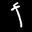

In [317]:
convert_values_to_image(training_letters_images.loc[0], True)

## Data Preprocessing

Image Normalization

In [318]:
training_letters_images_scaled = training_letters_images.values.astype('float32')/255
training_letters_labels = training_letters_labels.values.astype('int32')
testing_letters_images_scaled = testing_letters_images.values.astype('float32')/255
testing_letters_labels = testing_letters_labels.values.astype('int32')

In [319]:
print("Training images of letters after scaling")
print(training_letters_images_scaled.shape)
training_letters_images_scaled[0:5]

Training images of letters after scaling
(13440, 1024)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Encoding Categorical Labels

In [320]:
number_of_classes = 28

training_letters_labels_encoded = to_categorical(training_letters_labels-1, num_classes=number_of_classes)
testing_letters_labels_encoded = to_categorical(testing_letters_labels-1, num_classes=number_of_classes)


In [321]:
print(training_letters_labels_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


## Reshaping Input Images to 32x32x1

In [322]:
training_letters_images_scaled = training_letters_images_scaled.reshape([-1, 32, 32, 1])
testing_letters_images_scaled = testing_letters_images_scaled.reshape([-1, 32, 32, 1])

print(training_letters_images_scaled.shape, training_letters_labels_encoded.shape, testing_letters_images_scaled.shape, testing_letters_labels_encoded.shape)

(13440, 32, 32, 1) (13440, 28) (3360, 32, 32, 1) (3360, 28)


## Designing Model Architecture

In [323]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
def create_model(optimizer='adam', kernel_initializer='he_normal', activation='relu'):
    # create model
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(32, 32, 1), kernel_initializer=kernel_initializer, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())

    #Fully connected final layer
    model.add(Dense(28, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return model

## Model Summary And Visualization

In [324]:
model = create_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization_44 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_45 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 8, 8, 32)        

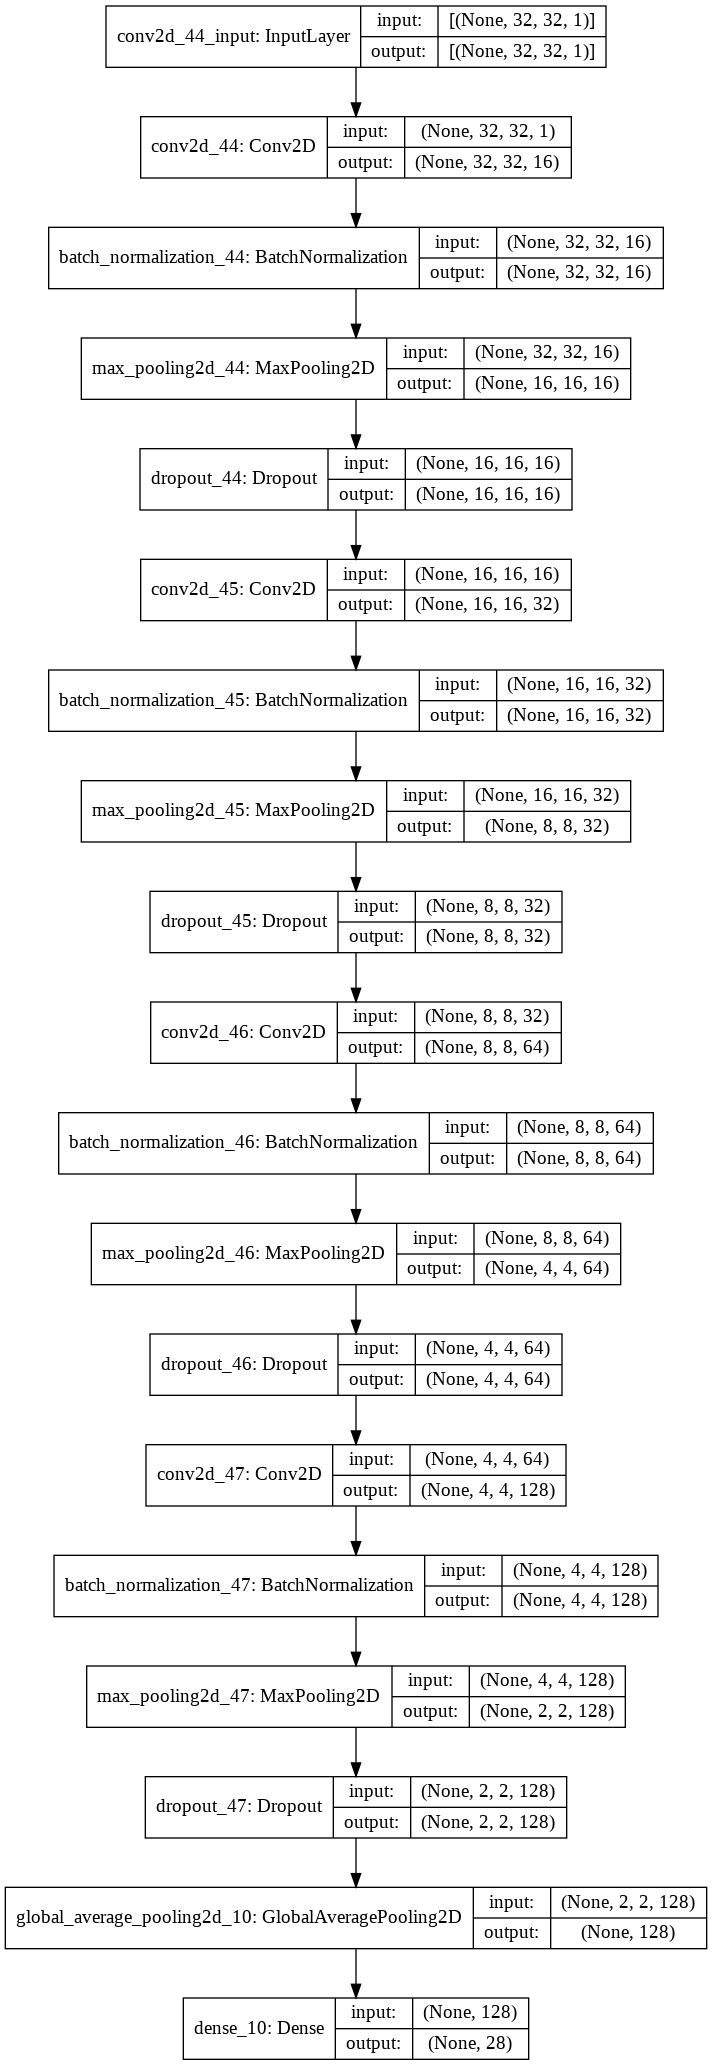

In [325]:
from keras.utils import plot_model
plot_model(model, to_file="model.png", show_shapes=True)
from IPython.display import Image as IPythonImage
display(IPythonImage('model.png'))

## Parameters Tuning

In [326]:
seed = 7
np.random.seed(seed)

# define the grid search parameters
optimizer = ['RMSprop', 'Adam', 'Adagrad', 'Nadam']
kernel_initializer = ['normal', 'uniform']
activation = ['relu', 'linear', 'tanh']

param_grid = dict(optimizer=optimizer, kernel_initializer=kernel_initializer, activation=activation)

# count number of different parameters values combinations
parameters_number = 1
for x in param_grid:
    parameters_number = parameters_number * len(param_grid[x]) 
print("Number of different parameter combinations = {}".format(parameters_number))

Number of different parameter combinations = 24


In [327]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [328]:
epochs = 200
batch_size = 64

In [329]:
model = create_model(optimizer='Adam', kernel_initializer='uniform', activation='relu')

## Training the Model

Fitting the Model

In [330]:
batch_size = 64
epochs = 200

train_gen = datagen.flow(x_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(x_test, y_test, batch_size=batch_size)

In [331]:
from keras.callbacks import ModelCheckpoint  

model_checkpoint_callback = ModelCheckpoint(
    filepath="best.hdf5",
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')


history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = x_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = x_test.shape[0] // batch_size,
                              callbacks=[model_checkpoint_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
210/210 [==============================] - 29s 134ms/step - loss: 2.6278 - accuracy: 0.2639 - val_loss: 6.1382 - val_accuracy: 0.0361

Epoch 00001: val_accuracy improved from -inf to 0.03606, saving model to best.hdf5
Epoch 2/200
210/210 [==============================] - 28s 132ms/step - loss: 0.8556 - accuracy: 0.7215 - val_loss: 3.8177 - val_accuracy: 0.0874

Epoch 00002: val_accuracy improved from 0.03606 to 0.08744, saving model to best.hdf5
Epoch 3/200
210/210 [==============================] - 28s 132ms/step - loss: 0.5797 - accuracy: 0.8130 - val_loss: 1.2872 - val_accuracy: 0.5727

Epoch 00003: val_accuracy improved from 0.08744 to 0.57272, saving model to best.hdf5
Epoch 4/200
210/210 [==============================] - 28s 132ms/step - loss: 0.4497 - accuracy: 0.8530 - val_loss: 0.7744 - val_accuracy: 0.7593

Epoch 00004: val_accuracy improved from 0.57272 to 0.75931, saving model to best.hdf5
Epoch 5/200
210/210 [==============================] - 28s 132ms/step -

## Plotting Loss and Accuracy Curves with Epochs

In [332]:
def plot_loss_accuracy(history):
    # Loss Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

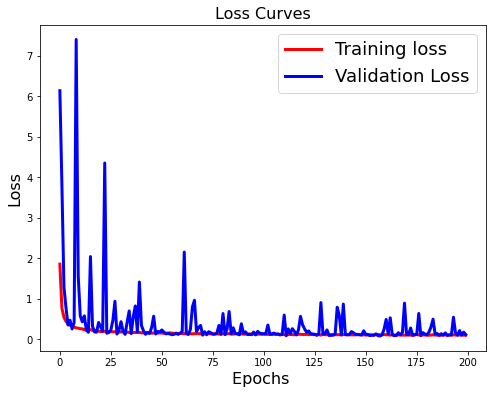

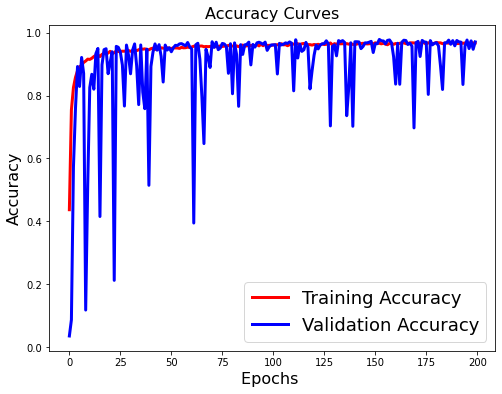

In [333]:
plot_loss_accuracy(history)

## Load the Model with the Best Validation Loss

In [334]:
model.load_weights('weights.hdf5')

## Test the Model

In [335]:
metrics = model.evaluate(testing_letters_images_scaled, testing_letters_labels_encoded, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

105/105 [==============================] - 2s 16ms/step - loss: 0.1060 - accuracy: 0.9714
Test Accuracy: 0.9714285731315613
Test Loss: 0.1060153990983963


Epoch 1/30
672/672 [==============================] - 28s 41ms/step - loss: 0.1201 - accuracy: 0.9594 - val_loss: 0.1296 - val_accuracy: 0.9667

Epoch 00001: val_loss improved from inf to 0.12962, saving model to weights.hdf5
Epoch 2/30
672/672 [==============================] - 27s 40ms/step - loss: 0.1056 - accuracy: 0.9659 - val_loss: 0.1675 - val_accuracy: 0.9574

Epoch 00002: val_loss did not improve from 0.12962
Epoch 3/30
672/672 [==============================] - 27s 40ms/step - loss: 0.0930 - accuracy: 0.9699 - val_loss: 0.1235 - val_accuracy: 0.9670

Epoch 00003: val_loss improved from 0.12962 to 0.12354, saving model to weights.hdf5
Epoch 4/30
672/672 [==============================] - 27s 41ms/step - loss: 0.0871 - accuracy: 0.9704 - val_loss: 0.1001 - val_accuracy: 0.9750

Epoch 00004: val_loss improved from 0.12354 to 0.10012, saving model to weights.hdf5
Epoch 5/30
672/672 [==============================] - 28s 42ms/step - loss: 0.0872 - accuracy: 0.9689 - val_loss: 0.12

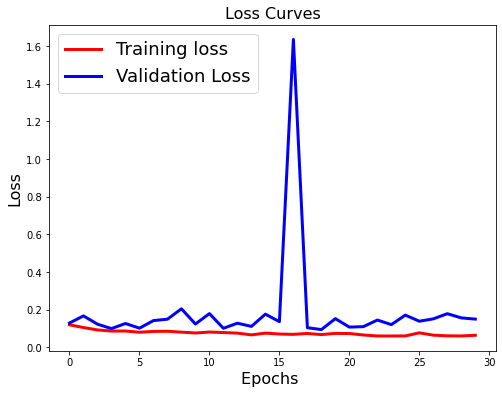

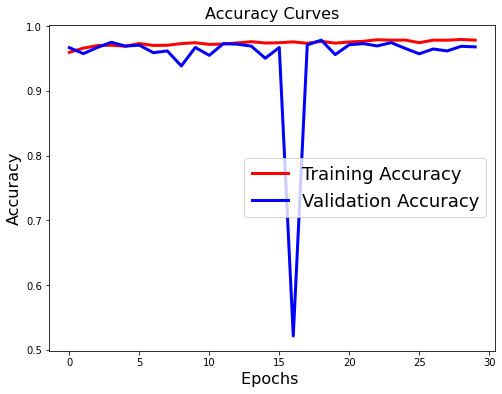

In [336]:
epochs = 30
batch_size = 20

checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(training_letters_images_scaled, training_letters_labels_encoded, 
                    validation_data=(testing_letters_images_scaled, testing_letters_labels_encoded),
                    epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[checkpointer])
          
model.load_weights('weights.hdf5')
plot_loss_accuracy(history)

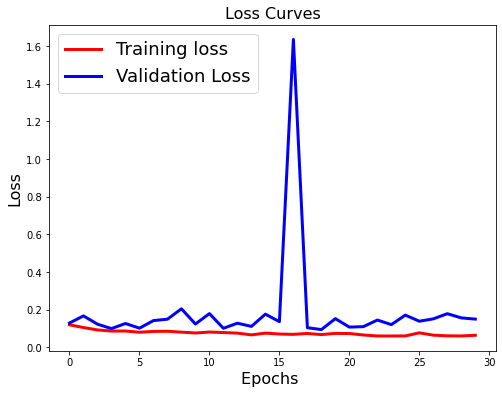

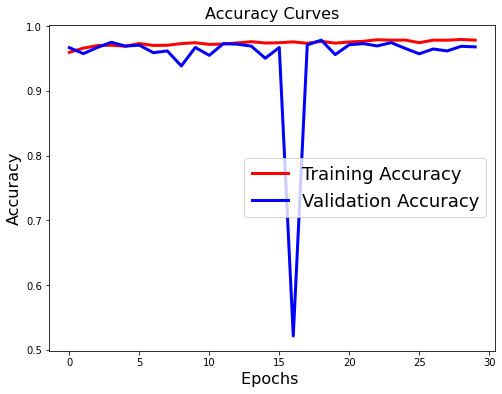

In [367]:
plot_loss_accuracy(history)

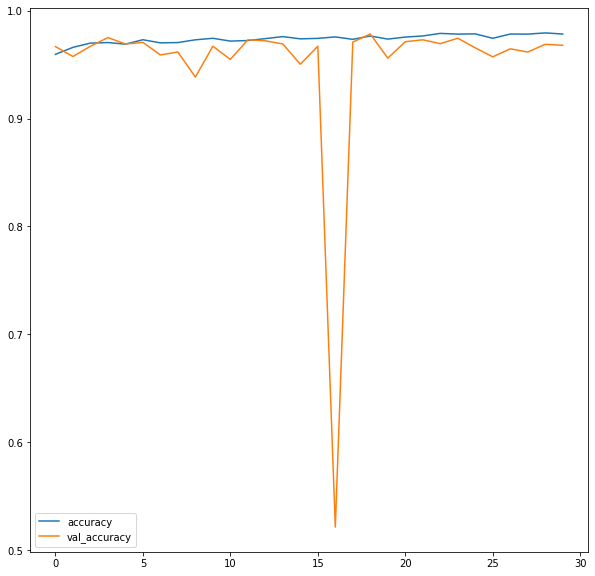

In [366]:
plt.figure(figsize=(10,10))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","val_accuracy"])
plt.show()

## Testing the Model again

In [365]:
# Final evaluation of the model
metrics = model.evaluate(testing_letters_images_scaled, testing_letters_labels_encoded, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

105/105 [==============================] - 2s 15ms/step - loss: 0.0948 - accuracy: 0.9783
Test Accuracy: 0.9782738089561462
Test Loss: 0.09481441974639893


## Saving the Final Model

In [368]:
from keras.models import model_from_yaml
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

Save the model weights to file.

In [369]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [370]:
# load YAML and create model
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# compile the loaded model
loaded_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

Loaded model from disk


## Predict Image Classes

In [371]:
def get_predicted_classes(model, data, labels=None):
    image_predictions = model.predict(data)
    predicted_classes = np.argmax(image_predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    return predicted_classes, true_classes, image_predictions

In [344]:
def get_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

In [345]:
!pip install Pillow

In [373]:
y_pred, y_true, image_predictions = get_predicted_classes(model, testing_letters_images_scaled, testing_letters_labels_encoded)
get_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       120
           1       1.00      0.99      1.00       120
           2       0.92      0.97      0.94       120
           3       0.97      0.93      0.95       120
           4       0.98      0.99      0.98       120
           5       0.99      0.97      0.98       120
           6       1.00      0.99      1.00       120
           7       0.99      0.95      0.97       120
           8       0.97      0.93      0.95       120
           9       0.93      1.00      0.96       120
          10       0.96      0.95      0.95       120
          11       0.99      1.00      1.00       120
          12       0.99      0.99      0.99       120
          13       0.97      0.99      0.98       120
          14       1.00      0.97      0.98       120
          15       0.95      1.00      0.98       120
          16       0.99      0.95      0.97       120
          17       0.98    

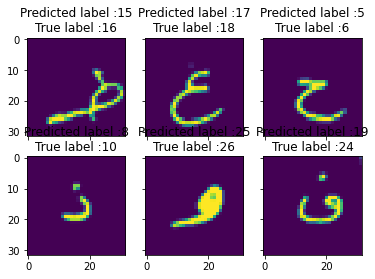

In [374]:
errors = (y_pred - y_true != 0)


Y_pred_classes_errors = y_pred[errors]
Y_pred_errors = image_predictions[errors]
Y_true_errors = y_true[errors]
X_val_errors = testing_letters_images_scaled[errors]


def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            
            image_array = img_errors[error]
            image_array = np.flip(image_array, 0)
            image_array = rotate(image_array, -90)
            
            
            ax[row,col].imshow((image_array).reshape((32,32)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted letters
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

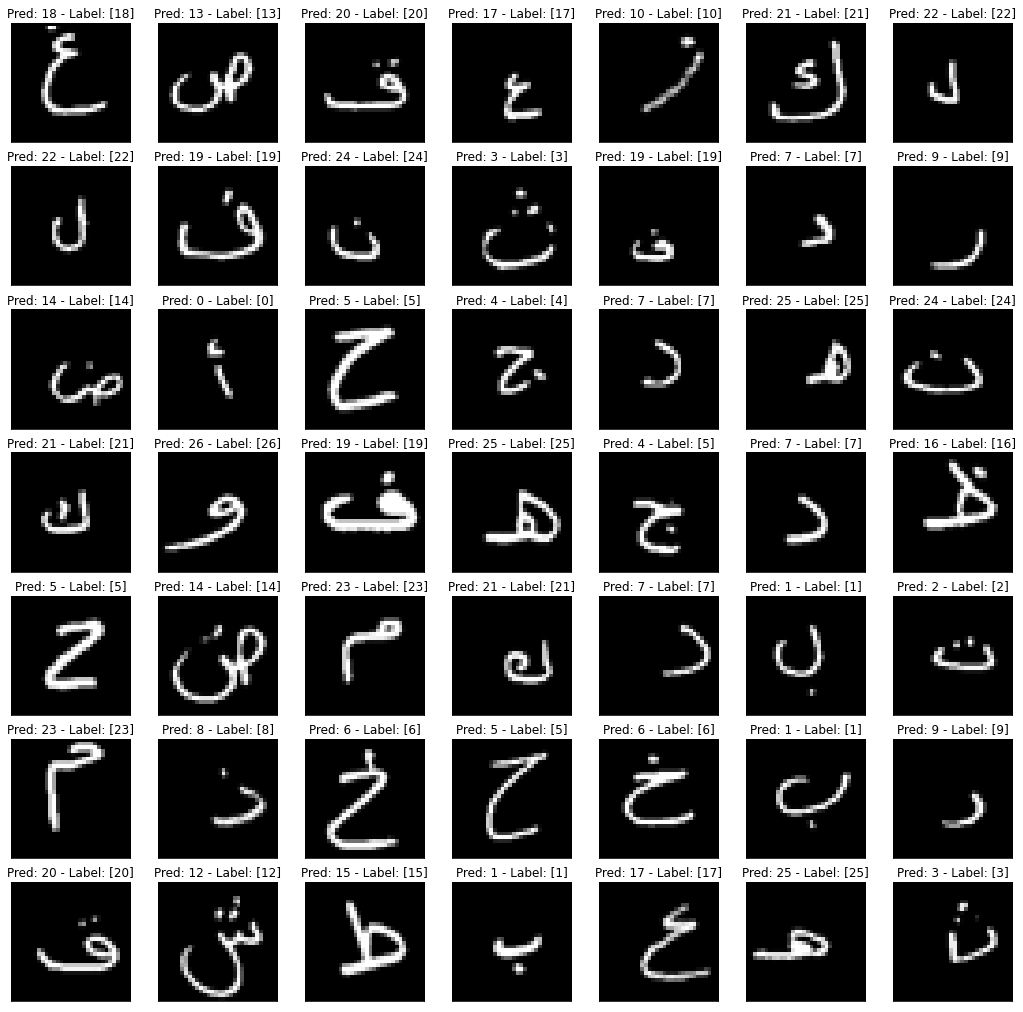

In [348]:
fig = plt.figure(0, figsize=(18,18))
indices = np.random.randint(0, testing_letters_labels.shape[0], size=49)
y_pred = np.argmax(model.predict(training_letters_images_scaled), axis=1)

for i, idx in enumerate(indices):
    plt.subplot(7,7,i+1)
        
    image_array = training_letters_images_scaled[idx][:,:,0]
    image_array = np.flip(image_array, 0)
    image_array = rotate(image_array, -90)
       
    plt.imshow(image_array, cmap='gray')
    plt.title("Pred: {} - Label: {}".format(y_pred[idx], (training_letters_labels[idx] -1)))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [375]:

x_train = pd.read_csv("csvTrainImages 13440x1024.csv",header=None).to_numpy()
y_train = pd.read_csv("csvTrainLabel 13440x1.csv",header=None).to_numpy()-1 

x_test = pd.read_csv("csvTestImages 3360x1024.csv",header=None).to_numpy()
y_test = pd.read_csv("csvTestLabel 3360x1.csv",header=None).to_numpy()-1

print("x_train.shape =", x_train.shape, "\ny_train.shape =", y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (13440, 1024) 
y_train.shape = (13440, 1) 
x_test.shape = (3360, 1024) 
y_test.shape = (3360, 1)


In [376]:
arabic_labels = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

(13440, 32, 32, 1) (3360, 32, 32, 1)


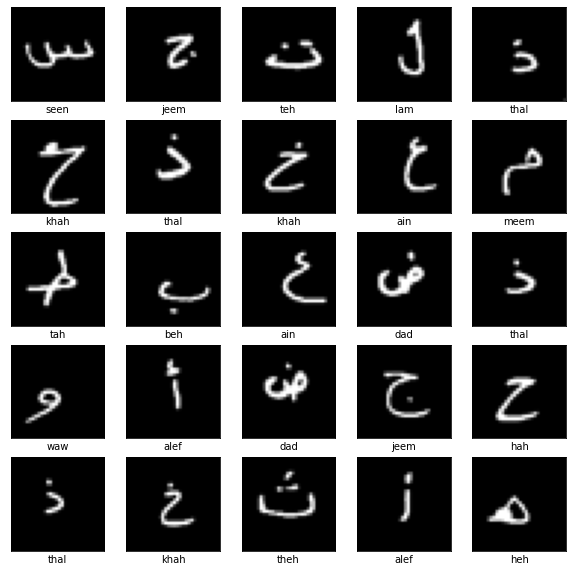

In [377]:
x_train = x_train.reshape(-1,32,32,1)
x_test = x_test.reshape(-1,32,32,1)

x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape, x_test.shape)

ra = np.random.randint(0, 13440, size=25)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[ra[i]].squeeze().T,"gray")
    plt.xlabel(arabic_characters[int(y_train[ra[i]][0])])
plt.show()


Text(0.5, 1.0, 'heh')

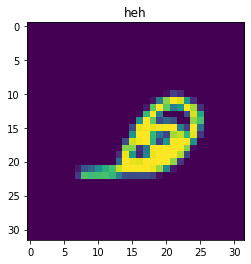

In [352]:
import random
x = random.randint(0, 13440)
plt.imshow(x_train[x].squeeze().T)
plt.title(arabic_labels[y_train[x][0]])

Text(0.5, 1.0, 'feh')

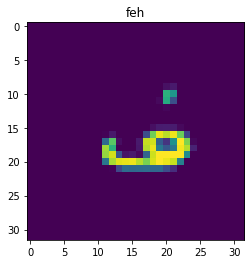

In [378]:
import random
x = random.randint(0, 13440)
plt.imshow(x_train[x].squeeze().T)
plt.title(arabic_labels[y_train[x][0]])

Text(0.5, 1.0, 'jeem')

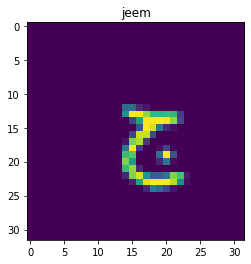

In [379]:
import random
x = random.randint(0, 13440)
plt.imshow(x_train[x].squeeze().T)
plt.title(arabic_labels[y_train[x][0]])

Text(0.5, 1.0, 'seen')

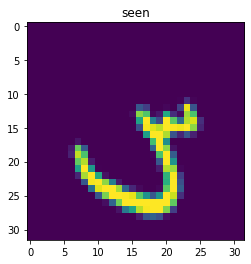

In [355]:
import random
x = random.randint(0, 13440)
plt.imshow(x_train[x].squeeze().T)
plt.title(arabic_labels[y_train[x][0]])

Text(0.5, 1.0, 'kaf')

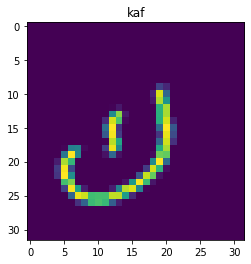

In [380]:
import random
x = random.randint(0, 13440)
plt.imshow(x_train[x].squeeze().T)
plt.title(arabic_labels[y_train[x][0]])

Text(0.5, 1.0, 'thal')

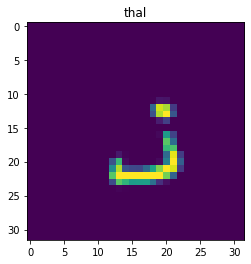

In [357]:
import random
x = random.randint(0, 13440)
plt.imshow(x_train[x].squeeze().T)
plt.title(arabic_labels[y_train[x][0]])

Text(0.5, 1.0, 'feh')

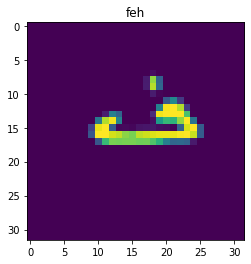

In [358]:
import random
x = random.randint(0, 13440)
plt.imshow(x_train[x].squeeze().T)
plt.title(arabic_labels[y_train[x][0]])

In [359]:
# Converting the class vector in integers to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape, y_test.shape)
for i in zip(y_train[0], arabic_characters):
    print(i)

(13440, 28) (3360, 28)
(1.0, 'alef')
(0.0, 'beh')
(0.0, 'teh')
(0.0, 'theh')
(0.0, 'jeem')
(0.0, 'hah')
(0.0, 'khah')
(0.0, 'dal')
(0.0, 'thal')
(0.0, 'reh')
(0.0, 'zain')
(0.0, 'seen')
(0.0, 'sheen')
(0.0, 'sad')
(0.0, 'dad')
(0.0, 'tah')
(0.0, 'zah')
(0.0, 'ain')
(0.0, 'ghain')
(0.0, 'feh')
(0.0, 'qaf')
(0.0, 'kaf')
(0.0, 'lam')
(0.0, 'meem')
(0.0, 'noon')
(0.0, 'heh')
(0.0, 'waw')
(0.0, 'yeh')


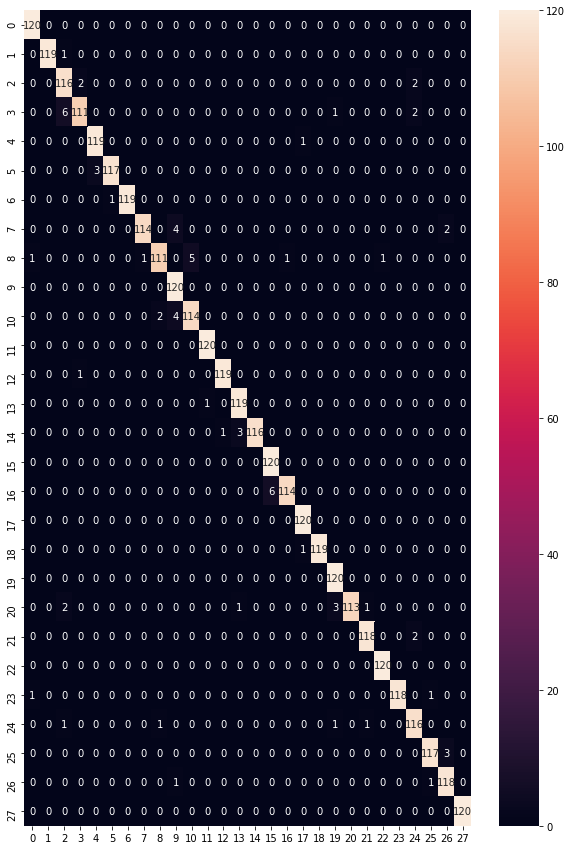

In [360]:
y_preds = model.predict(x_test)
y_pred_classes = np.argmax(y_preds, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,15))
sn.heatmap(cm, annot=True, fmt="d")